# Loading the libraries

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from IPython.display import display
from PIL import Image
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

2.1.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15693488679408105966
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16655173313011042324
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Loading model

In [2]:
model = tf.keras.models.load_model('model_512_batches_27july2020_epoch14/')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 231, 231, 8)       608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 115, 115, 8)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 115, 115, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 8)       1608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 16)        1

In [4]:
import pickle

with open('testing_banded.pickle', 'rb') as f:
    testing_banded_np = pickle.load(f)
f.close()

with open('testing_non_banded.pickle', 'rb') as f:
    testing_non_banded_np = pickle.load(f)
f.close()


print(" testing_banded_np done",testing_banded_np.shape)

print(" testing_non_banded_np done",testing_non_banded_np.shape) 

 testing_banded_np done (7476, 235, 235, 3)
 testing_non_banded_np done (9564, 235, 235, 3)


## loading data folder in image format using tensorflow

In [5]:
y_test_banded = model.predict(testing_banded_np/255.0)
print(y_test_banded.shape)

(7476, 1)


In [6]:
y_test_non_banded1 = model.predict(testing_non_banded_np[:3000]/255.0)

In [7]:
y_test_non_banded2 = model.predict(testing_non_banded_np[3000:6000]/255.0)

In [8]:
y_test_non_banded3 = model.predict(testing_non_banded_np[6000:]/255.0)

In [9]:
print(y_test_non_banded1.shape)
print(y_test_non_banded2.shape)
print(y_test_non_banded3.shape)

(3000, 1)
(3000, 1)
(3564, 1)


In [10]:
import numpy as np

In [11]:
y_test_non_banded = np.concatenate((y_test_non_banded1,y_test_non_banded2,y_test_non_banded3),axis=0)

In [12]:
with open('y_test_banded.pickle', 'wb') as f:
    pickle.dump(y_test_banded, f)
f.close()

In [13]:
with open('y_test_non_banded.pickle', 'wb') as f:
    pickle.dump(y_test_non_banded, f)
f.close()

In [14]:
y_test_non_banded.shape

(9564, 1)

## resversing predictions for making banding as positive result

In [15]:
y_test_banded1 = 1 - y_test_banded

In [16]:
y_test_non_banded1 = 1 - y_test_non_banded

In [17]:
y_test_banded1

array([[0.9966008 ],
       [0.9985055 ],
       [0.9990041 ],
       ...,
       [0.9552649 ],
       [0.99997306],
       [0.9859717 ]], dtype=float32)

In [18]:
y_test_non_banded1

array([[0.00554723],
       [0.05547214],
       [0.07592112],
       ...,
       [0.00700599],
       [0.22521937],
       [0.01014459]], dtype=float32)

## writing y=1 for banded and y = 0 for non banded

In [19]:
y_test_banded_actual = np.ones((y_test_banded1.shape[0],1))

In [20]:
y_test_non_banded_actual = np.zeros((y_test_non_banded1.shape[0],1))

## concatinating banded and non banded results

In [21]:
Y_test_pred = np.concatenate((y_test_banded1,y_test_non_banded1),axis=0)

In [22]:
Y_test_actual = np.concatenate((y_test_banded_actual,y_test_non_banded_actual),axis=0)

In [23]:
Y_test_pred.shape

(17040, 1)

In [24]:
Y_test_actual.shape

(17040, 1)

## Lets try ROC curve from Sklearn

In [25]:
from sklearn import metrics

In [26]:
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(Y_test_actual, Y_test_pred)

In [27]:
auc = metrics.roc_auc_score(Y_test_actual,Y_test_pred)
print('AUC: %.3f' % auc)

AUC: 0.964


Text(0.5, 1.0, 'ROC curve for model performance')

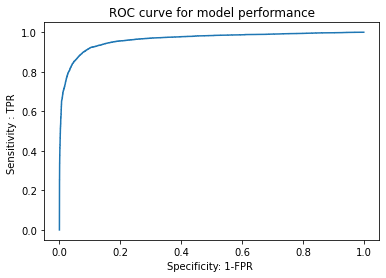

In [34]:
import matplotlib.pyplot as plt
plt.plot(fpr_test, tpr_test)
plt.xlabel("Specificity: 1-FPR ")
plt.ylabel("Sensitivity : TPR ")
plt.title("ROC curve for model performance")


## Plotting Precision Recall Curve

In [41]:
precision,recall,threshold = metrics.precision_recall_curve(Y_test_actual, Y_test_pred)

In [42]:
f1_score = []
for i in range(len(precision)):
    prec = precision[i]
    recl = recall[i]
    f1_temp = 2*prec*recl/(prec+recl)
    f1_score.append(f1_temp)

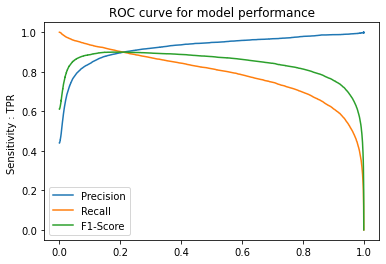

In [47]:
import matplotlib.pyplot as plt
plt.plot(threshold,precision[:-1],label = "Precision")
plt.plot(threshold,recall[:-1], label = "Recall")
plt.plot(threshold,f1_score[:-1], label = "F1-Score")
plt.ylabel("Sensitivity : TPR ")
plt.title("ROC curve for model performance")
plt.legend()


# Finding the optimal values of threshold

In [48]:
for i in range(len(precision)):
    prec = precision[i]
    recl = recall[i]
    if (prec == recl):
        print(threshold[i])
        break

0.20915085


## Lets make a function that returns TPs FPs and all for a given number of examples

In [49]:
def tell_me_the_matrix (a1, a2, threshold):
    actual = a1
    pred = a2
    num_samples = actual.shape[0]
    temp = np.zeros((num_samples,1))

    for i in range(num_samples):
        if(pred[i,:]>=threshold):
            temp[i,:]=1
        else :
            temp[i,:]=0
            
    print(temp-a2)
            
    #TP
    TP = 0
    #print(threshold)
    for i in range(num_samples):
        if (temp[i,:]==1) and (actual[i,:]==1):
            TP+=1
    print("True positives are ", TP)
    
    #FP
    FP = 0 
    for i in range(num_samples):
        if (temp[i,:]==1) and (actual[i,:]==0):
            FP+=1
    print("False positives are ", FP)
        
    #TN
    TN = 0 
    for i in range(num_samples):
        if (temp[i,:]==0) and (actual[i,:]==0):
            TN+=1
    print("True Negatives are ", TN)    
    
    #FN
    FN = 0 
    for i in range(num_samples):
        if (temp[i,:]==0) and (actual[i,:]==1):
            FN+=1
    print("False Negatives are ", FN)      
    
    return [TP,FP,TN,FN]    
    

In [50]:
import pandas as pd

In [61]:
accuracy =[]
TP = []
FP = []
TN = []
FN = []
TPR = []
FPR = []
Precision = []
Recall = []
F1_score = []
list_t = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.50,0.55,0.6,0.65,0.7,0.75,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
for i in list_t:
    a = tell_me_the_matrix(Y_test_actual, Y_test_pred,i)
    total = a[0]+a[1]+a[2]+a[3]
    TP.append(a[0]*100/total)
    FP.append(a[1]*100/total)
    TN.append(a[2]*100/total)
    FN.append(a[3]*100/total)
    Precision.append(a[0]/(a[0]+a[1]))
    Recall.append(a[0]/(a[0]+a[3]))
    accuracy.append((a[0]+a[2])/total)
    TPR.append(a[0]/(a[0]+a[3]))
    FPR.append(a[2]/(a[1]+a[2]))
    pr = a[0]/(a[0]+a[1])
    re = a[0]/(a[0]+a[3])
    F1_score.append(2*pr*re/(pr+re))

[[ 0.00339919]
 [ 0.00149453]
 [ 0.00099587]
 ...
 [-0.00700599]
 [ 0.77478063]
 [-0.01014459]]
True positives are  7161
False positives are  2048
True Negatives are  7516
False Negatives are  315
[[ 0.00339919]
 [ 0.00149453]
 [ 0.00099587]
 ...
 [-0.00700599]
 [ 0.77478063]
 [-0.01014459]]
True positives are  6998
False positives are  1315
True Negatives are  8249
False Negatives are  478
[[ 0.00339919]
 [ 0.00149453]
 [ 0.00099587]
 ...
 [-0.00700599]
 [ 0.77478063]
 [-0.01014459]]
True positives are  6878
False positives are  953
True Negatives are  8611
False Negatives are  598
[[ 0.00339919]
 [ 0.00149453]
 [ 0.00099587]
 ...
 [-0.00700599]
 [ 0.77478063]
 [-0.01014459]]
True positives are  6748
False positives are  784
True Negatives are  8780
False Negatives are  728
[[ 0.00339919]
 [ 0.00149453]
 [ 0.00099587]
 ...
 [-0.00700599]
 [-0.22521937]
 [-0.01014459]]
True positives are  6628
False positives are  664
True Negatives are  8900
False Negatives are  848
[[ 0.00339919]
 [ 

In [62]:
dict_val = {'accuracy':accuracy,'TP':TP,'FP':FP,'TN':TN,'FN':FN,'TPR':TPR,'FPR':FPR,'Precision':Precision,'Recall':Recall,'F1_score':F1_score}

In [63]:
df_val = pd.DataFrame.from_dict(dict_val) 

In [64]:
df_val['ind'] =list_t

In [65]:
df_val.set_index('ind')

,accuracy,TP,FP,TN,FN,TPR,FPR,Precision,Recall,F1_score
ind,,,,,,,,,,
0.05,0.861326,42.024648,12.018779,44.107981,1.848592,0.957865,0.785864,0.777609,0.957865,0.858376
0.10,0.894777,41.068075,7.717136,48.409624,2.805164,0.936062,0.862505,0.841814,0.936062,0.886440
0.15,0.908979,40.363850,5.592723,50.534038,3.509390,0.920011,0.900355,0.878304,0.920011,0.898674
0.20,0.911268,39.600939,4.600939,51.525822,4.272300,0.902622,0.918026,0.895911,0.902622,0.899254
0.25,0.911268,38.896714,3.896714,52.230047,4.976526,0.886570,0.930573,0.908941,0.886570,0.897616
0.30,0.909977,38.251174,3.380282,52.746479,5.622066,0.871857,0.939774,0.918805,0.871857,0.894715
0.35,0.908216,37.611502,2.916667,53.210094,6.261737,0.857277,0.948034,0.928034,0.857277,0.891253
0.40,0.906162,37.007042,2.517606,53.609155,6.866197,0.843499,0.955144,0.936303,0.843499,0.887482
0.45,0.902993,36.349765,2.177230,53.949531,7.523474,0.828518,0.961209,0.943488,0.828518,0.882273


In [66]:
df_val.to_csv(r'test_TPFP14epochs.csv', index = True)